In [60]:
# importing some libraries (not all are currently used)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar


# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


# 1.0 Loading Data

In [62]:
df = pd.read_csv('train.csv')

In [63]:
# get the locations
X = df.iloc[:, :]
y = df.iloc[:, :]

# split the dataset
train_set, test_set, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [64]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128) # 32 * 7 * 7, 128
        self.fc2 = nn.Linear(128, 5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        #print("we're here")
        #print(x.shape)
        x = x.view(-1, 32 * 56 * 56) # 32 * 7 * 7
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return x


# Instantiate the model
model = SimpleCNN()

In [65]:
class RetinaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = f"{self.root_dir}/{self.labels_frame.iloc[idx, 0]}" + '.png'
        image = Image.open(img_name)
        label = int(self.labels_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,))
])




# Create datasets and dataloaders
trainset = RetinaDataset(csv_file=train_set, root_dir='train_images', transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset = RetinaDataset(csv_file=test_set, root_dir='train_images', transform=transform)
validloader = DataLoader(validset, batch_size=64, shuffle=False)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Model

In [67]:
model = torch.load('model_CNN2.pt')
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



def train(model, train_loader, valid_loader, criterion, optimizer, epochs=1):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_fprs, train_tprs, train_auc_scores = [], [], []
    valid_fprs, valid_tprs, valid_auc_scores = [], [], []
    train_f1s, valid_f1s = [], []
    train_tp, train_tn, train_fp, train_fn = [], [], [], []
    valid_tp, valid_tn, valid_fp, valid_fn = [], [], [], []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        all_train_labels, all_train_preds = [], []
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs.shape)
            #print(labels.shape)
            #print(inputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            # Collect data for AUROC and F1 score
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # ROC Curve
        all_train_labels = np.array(all_train_labels)
        all_train_preds = np.array(all_train_preds)
        fpr_train, tpr_train, thresholds_train = roc_curve(all_train_labels, all_train_preds[:, 1])  # Assuming binary classification
        roc_auc_train = auc(fpr_train, tpr_train)

        # Calculate confusion matrix and TP, TN, FP, FN
        cm = confusion_matrix(all_train_labels, np.argmax(all_train_preds, axis=1))
        tp = np.diag(cm)
        fn = np.sum(cm, axis=1) - tp
        fp = np.sum(cm, axis=0) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        train_tp.append(tp)
        train_tn.append(tn)
        train_fp.append(fp)
        train_fn.append(fn)


        # Calculate AUROC and F1 score
        all_train_labels = np.array(all_train_labels)
        all_train_preds = np.array(all_train_preds)
        train_auroc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovr') if len(np.unique(all_train_labels)) > 1 else float('nan')
        train_f1 = f1_score(all_train_labels, np.argmax(all_train_preds, axis=1), average='weighted')




        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_aurocs.append(train_auroc)
        train_f1s.append(train_f1)
        train_fprs.append(fpr_train)
        train_tprs.append(tpr_train)

        # VALIDATION STEPS

        # loss, accuracy, f1s, aurocs
        valid_loss, valid_accuracy, valid_auroc, valid_f1, valid_tp_epoch, valid_tn_epoch, valid_fp_epoch, valid_fn_epoch, all_valid_labels, all_valid_preds = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_aurocs.append(valid_auroc)
        valid_f1s.append(valid_f1)

        # Roc CURVE
        fpr_valid, tpr_valid, thresholds_valid = roc_curve(all_valid_labels, all_valid_preds[:, 1])  # Assuming binary classification
        roc_auc_valid = auc(fpr_valid, tpr_valid)

        # tp, tn, fp, fn

        valid_tp.append(valid_tp_epoch)
        valid_tn.append(valid_tn_epoch)
        valid_fp.append(valid_fp_epoch)
        valid_fn.append(valid_fn_epoch)
        valid_fprs.append(fpr_valid)
        valid_tprs.append(tpr_valid)


        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}: Train Loss: {round(train_loss, 3)}, Train Accuracy: {round(train_accuracy, 3)}%, Valid Loss: {round(valid_loss, 3)}, Valid Accuracy: {round(valid_accuracy, 3)}%")
        print(f"Train auroc: {round(train_auroc, 3)}, Train f1: {round(train_f1, 3)}%, Valid auroc: {round(valid_auroc, 3)}, Valid f1: {round(valid_f1, 3)}%")
    return (train_losses, valid_losses, train_accuracies, valid_accuracies,
            train_aurocs, valid_aurocs,
            train_tp, train_tn, train_fp, train_fn,
            valid_tp, valid_tn, valid_fp, valid_fn)

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_valid_labels, all_valid_preds = [], []
    all_valid_labels, all_valid_preds = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    # Calculate AUROC and F1 score
    all_valid_labels = np.array(all_valid_labels)
    all_valid_preds = np.array(all_valid_preds)
    valid_auroc = roc_auc_score(all_valid_labels, all_valid_preds, multi_class='ovr') if len(np.unique(all_valid_labels)) > 1 else float('nan')
    valid_f1 = f1_score(all_valid_labels, np.argmax(all_valid_preds, axis=1), average='weighted')


    # Calculate confusion matrix and TP, TN, FP, FN
    cm = confusion_matrix(all_valid_labels, np.argmax(all_valid_preds, axis=1))
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    return valid_loss, valid_accuracy, valid_auroc, valid_f1, tp, tn, fp, fn, all_valid_labels, all_valid_preds


# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies, train_aurocs, valid_aurocs, train_tp, train_tn, train_fp, train_fn, valid_tp, valid_tn, valid_fp, valid_fn = train(model, trainloader, validloader, criterion, optimizer, epochs=1)


ValueError: multiclass format is not supported

In [ ]:
torch.save(model, 'model_CNN2.pt')

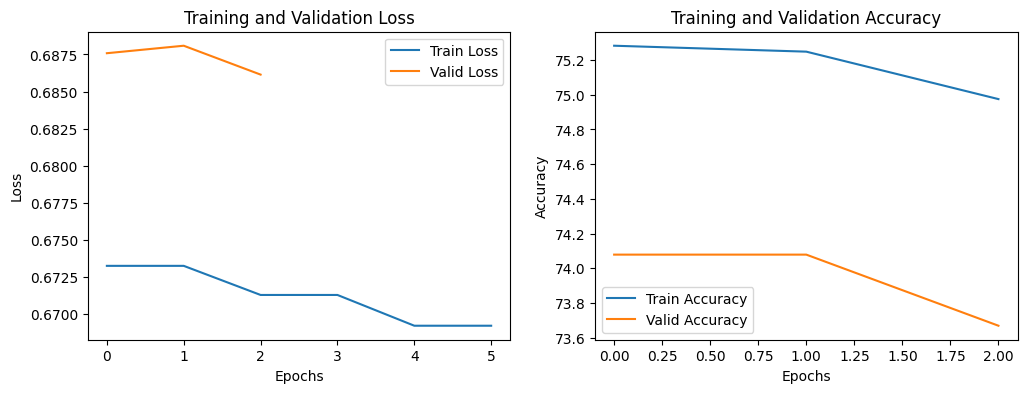

In [29]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

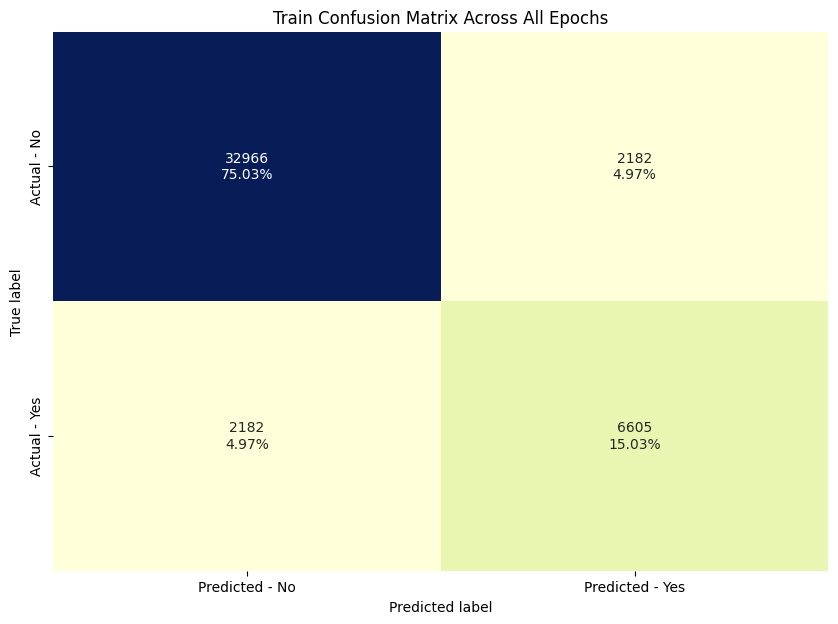

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(train_tp, train_tn, train_fp, train_fn, labels=['No', 'Yes']):
    # Calculate metrics from TP, TN, FP, FN
    cm = np.array([[np.sum(train_tn), np.sum(train_fp)],
                   [np.sum(train_fn), np.sum(train_tp)]])

    # Create DataFrame for confusion matrix
    df_cm = pd.DataFrame(cm, index=[f'Actual - {labels[0]}', f'Actual - {labels[1]}'],
                         columns=[f'Predicted - {labels[0]}', f'Predicted - {labels[1]}'])

    # Create annotations for each cell
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plotting the heatmap with adjusted color scheme
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='YlGnBu', cbar=False)  # Change 'cmap' to adjust the color scheme
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Train Confusion Matrix Across All Epochs')
    plt.show()

# Example usage:
make_confusion_matrix(train_tp, train_tn, train_fp, train_fn)

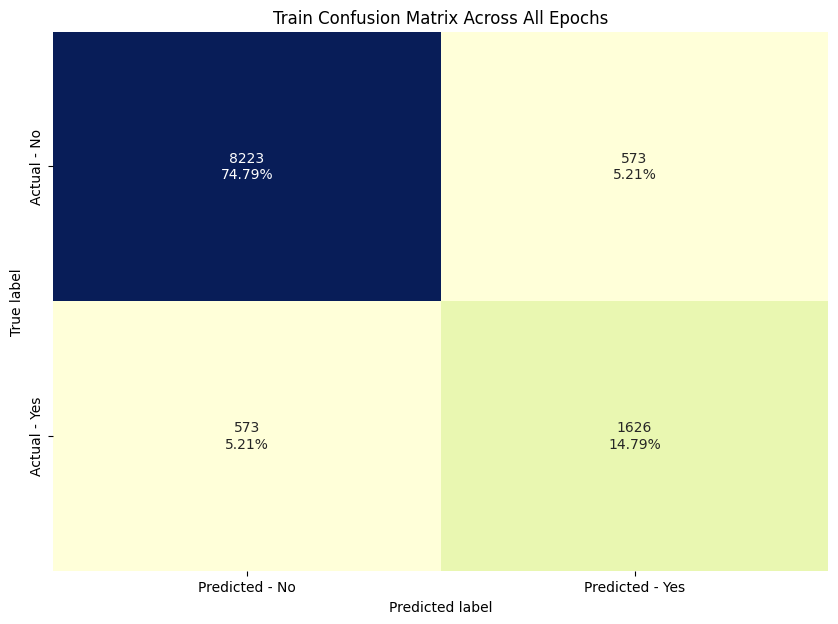

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(train_tp, train_tn, train_fp, train_fn, labels=['No', 'Yes']):
    # Calculate metrics from TP, TN, FP, FN
    cm = np.array([[np.sum(train_tn), np.sum(train_fp)],
                   [np.sum(train_fn), np.sum(train_tp)]])

    # Create DataFrame for confusion matrix
    df_cm = pd.DataFrame(cm, index=[f'Actual - {labels[0]}', f'Actual - {labels[1]}'],
                         columns=[f'Predicted - {labels[0]}', f'Predicted - {labels[1]}'])

    # Create annotations for each cell
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plotting the heatmap with adjusted color scheme
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='YlGnBu', cbar=False)  # Change 'cmap' to adjust the color scheme
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Train Confusion Matrix Across All Epochs')
    plt.show()

# Example usage:
make_confusion_matrix(valid_tp, valid_tn, valid_fp, valid_fn)

In [54]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(len(train_fprs)):
    plt.plot(train_fprs[i], train_tprs[i], lw=2, label=f'Train ROC curve (AUC = {train_auc_scores[i]:.2f})')
for i in range(len(valid_fprs)):
    plt.plot(valid_fprs[i], valid_tprs[i], lw=2, linestyle='--', label=f'Validation ROC curve (AUC = {valid_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

NameError: name 'train_fprs' is not defined

<Figure size 1000x600 with 0 Axes>